## Implementation of Genetic Algorithm for Feature Selection
________
##### 1) 무작위 모집단을 생성 및 초기화하는 함수를 실행
##### 2) 생성된 무작위 모집단은 적합도 검정을 통해 최적의 parent를 판단 (가장 높은 정확도)
##### 3) n-parent 매개변수에 따라 무작위 모집단에서 가장 좋은 적합도의 최적의 parent를 개수만큼 선택
##### 4) 동일한 작업을 수행한 후, crossover 및 mutation 기능을 진행
##### 5) crossover는 가장 적합한 두 parents에 대해 첫 번째 parent의 유전자의 일부와 두 번째 parent의 유전자의 일부를 무작위로 선택하여 결합
##### 6) mutation은 crossover child에 대해 mutation rate를 설정하고 num_feature에 비례하게 개수를 선택 후 무작위로 뒤집음으로써 달성
##### 7) 이전 세대에서 가장 적합한 parent를 선택하고 crossover 및 mutation를 적용하여 새로운 세대가 생성
##### 8) 이 과정을 n세대 동안 반복
______

# Regression part

## import module

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from random import randint
import random

## Load Dataset & Preprocessing

- regression case를 위해 Bike Sharing Demand Dataset 사용 (Kaggle dataset)
- feature: ["datetime", "season", "holiday", "workingday", "weather", "temp", "atemp", "humidity", "windspeed", "casual", "registered"]
- target: ["count"]

In [2]:
bike_df = pd.read_csv('./bike_train.csv')
print(bike_df.shape)
bike_df.head(3)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [3]:
# 문자열을 datetime 타입으로 변경. 
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x: x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


In [4]:
drop_columns = ['datetime','casual','registered']
bike_df.drop(drop_columns, axis=1, inplace=True)

- 데이터를 Training, Testing Set으로 분할 (75:25)
- Model은 기본 Linear Regression 모델 사용

In [5]:
from sklearn.model_selection import train_test_split
def split(df, label):
    X_tr, X_te, Y_tr, Y_te = train_test_split(df, label, test_size=0.25, random_state=42)
    return X_tr, X_te, Y_tr, Y_te

y_target = bike_df['count']
X_features = bike_df.drop(['count'],axis=1,inplace=False)

X_train, X_test, y_train, y_test = split(X_features, y_target)

In [6]:
from sklearn.linear_model import LinearRegression
lr_reg = LinearRegression()

## Genetic Algorithm

### Step 1 (Initialization)

- Population을 초기화하여 Chromosome(염색체) 벡터를 binary값으로 인코딩 (0, 1)

In [7]:
num_features = X_train.shape[1] 
num_population = 30

def initilization_of_population(num_population, num_features):
    population = []
    for i in range(num_population):
        chromosome = np.ones(num_features, dtype=np.int)
        chromosome[:int(0.5*num_features)]=False             
        np.random.shuffle(chromosome)
        chromosome = list(chromosome)
        population.append(chromosome)
    return population

population = initilization_of_population(num_population, num_features)
population

C:\Users\YongGon\AppData\Local\Temp/ipykernel_12196/2423685752.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  chromosome = np.ones(num_features, dtype=np.int)


[[0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0],
 [1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
 [0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0],
 [0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0],
 [1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0],
 [1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1],
 [0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0],
 [1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0],
 [0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0],
 [0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1],
 [1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1],
 [1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1],
 [1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0],
 [1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0],
 [1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0],
 [1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1],
 [1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0],
 [1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1],
 [0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
 [1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0],
 [0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1],
 [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1],
 [1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1],
 [1, 0, 0, 0, 0, 0, 1, 1,

In [8]:
np.array(population).shape

(30, 12)

### Step 2. Fitting Models & Step 3. Fitness Evaluation

- Linear Model을 Fitting하고, Fitting된 모델데 대한 적합도를 평가하여 Score를 저장

In [9]:
# calculate chromosome scores
score = -99999

def fitness_score(population):
    scores = []
    for chromosome in population:
        if sum(chromosome) == 0: # Chromosome에 1이 하나도 없을 때
            score = -999999 
        else:
            chromosome_selected = [bool(chromo) for chromo in chromosome] 
            X_train_selected = X_train.loc[:, chromosome_selected]
            X_test_selected = X_test.loc[:, chromosome_selected]

            lr_reg.fit(X_train_selected, y_train)
            score = lr_reg.score(X_test_selected, y_test) 

        scores.append(score)
    return scores

scores_chromosome = fitness_score(population)

- 초기 Population 안의 각 Chromosome(염색체)을 이용해 선택한 feature를 사용해 linear regression에 fitting한 결과 계산된 score 값

In [10]:
scores_chromosome

[0.2550839220022102,
 0.14973189332883674,
 0.2392741043659684,
 0.1909470547449078,
 0.2411152064888914,
 0.2532582257729059,
 0.23922525147525453,
 0.15012246741890167,
 0.31962421945555297,
 0.2927755457855141,
 0.3331773642854555,
 0.24067281949797437,
 0.2712127132556066,
 0.14979624462440966,
 0.25565906130643223,
 0.2792217130388823,
 0.1772247773534783,
 0.33248794705947504,
 0.2460952382912821,
 0.3041370549225161,
 0.24060455554179416,
 0.2578800138915215,
 0.31957611319359525,
 0.24800014065795173,
 0.331066034170035,
 0.21367383564017073,
 0.29193432002805253,
 0.2565700896083707,
 0.30270308978100635,
 0.2823819948840933]

### Step 4. Select Parent Chromosome

- Selection, Deterministic(단순 rank만 고려)/Probabilistic(확률값 고려) selection이 존재
- Score를 기반으로 Parent Chromosome을 선택하고, 본 실험에서는 구성된 Population의 상위 50%만을 Parent로 선택합니다.

In [11]:
# Step 4. Select Parent Chromosome
num_deterministic_selection = int(np.round(num_population * 0.5))

parent_chromosome_index = np.array(scores_chromosome).argsort()[-num_deterministic_selection:]
# best_parent_chromosome_index = np.array(scores_chromosome).argsort()[-1]

candidate_parent_chromosome = np.array(population)[parent_chromosome_index]
candidate_parent_score = np.array(scores_chromosome)[parent_chromosome_index]
curr_best_parent_chromosome = np.array(population)[parent_chromosome_index][-1]
curr_best_parent_score = np.array(scores_chromosome)[parent_chromosome_index][-1]

In [12]:
print(curr_best_parent_chromosome)
print(curr_best_parent_score)

[1 0 0 0 1 0 1 0 0 1 1 1]
0.3331773642854555


### Step 5. Crossover, Step 6. Mutation - Generation Iteration

- Generation Iteration을 통하여 Crossover와 Mutation을 동시에 진행
- 새로운 Child Chromosome으로 구성된 Population을 만들어냄
- 가장 좋은 Best(Elite) Chromosome은 Population에 항상 1개를 추가함

Crossover(교배) & Mutation(돌연변이), 두 자식 염색체에서의 교배 및 돌연변이  diversity 증가
Final the best variable subset, 적합도가 가장 높은 염색체만은 선택함

In [13]:
max_generation = 1000
score_history = []


for generation in range(max_generation):
    childs = []
    childs.append(curr_best_parent_chromosome) # Best는 무조건 1개 넣어준다.

    while len(childs) < num_population :
        # 현재의 선택된 Best Parenet 중에서 random으로 좋은 애들 2개를 선택함
        select_2 = random.sample(list(range(len(candidate_parent_score))), 2)
        winner_p1 = candidate_parent_chromosome[min(select_2, key=lambda idx: candidate_parent_score[idx])]

        select_2 = random.sample(list(range(len(candidate_parent_score))), 2)
        winner_p2 = candidate_parent_chromosome[min(select_2, key=lambda idx: candidate_parent_score[idx])]
        
        # cross-over
        c1 = []
        c2 = []
        for i in range(len(winner_p1)):
            if random.random() < 0.5: # Random Crossover (50%)
                c1.append(winner_p1[i])
                c2.append(winner_p2[i])
            else:
                c1.append(winner_p2[i])
                c2.append(winner_p1[i])
        
        # mutation
        if random.random() <= 0.2:
            idx_mutation = random.randrange(0,len(c1))
            c1[idx_mutation] = 1 - c1[idx_mutation]
        if random.random() <= 0.2:
            idx_mutation = random.randrange(0,len(c2))
            c2[idx_mutation] = 1 - c2[idx_mutation]
        
        childs.append(c1)
        if len(childs) < num_population:
            childs.append(c2)
    


    score_history.append([generation, np.max(scores_chromosome), np.std(scores_chromosome)])

    population = childs 
    scores_chromosome = fitness_score(population)    
    
    num_deterministic_selection = int(np.round(num_population * 0.5))

    parent_chromosome_index = np.array(scores_chromosome).argsort()[-num_deterministic_selection:]

    candidate_parent_chromosome = np.array(population)[parent_chromosome_index]
    candidate_parent_score = np.array(scores_chromosome)[parent_chromosome_index]

    curr_best_parent_chromosome = np.array(population)[parent_chromosome_index][-1]
    curr_best_parent_score = np.array(scores_chromosome)[parent_chromosome_index][-1]


print("best parent score : ", curr_best_parent_score)

best_index = np.argmax(candidate_parent_score)
best_score = candidate_parent_score[best_index]
best_parent_chromosome = candidate_parent_chromosome[best_index]

best parent score :  0.3878082388952133


- Scoe History를 저장
- Best Chromosome을 찾아서, 해당 Score를 출력하고 선택된 Feature를 표현한다.

In [14]:
score_history = np.array(score_history)

In [15]:
print(f'Best Score : {best_score}')
print(f'Best Parent Chromosome : {best_parent_chromosome}')

Best Score : 0.3878082388952133
Best Parent Chromosome : [1 0 0 1 1 1 1 1 1 1 1 1]


# Classification part

- 위 회귀 파트에서는 설명을 위해 예시를 하나씩 보여주는 형태로 진행했다면,
- 본 예제에서는 다양한 모델을 사용했을 때 GA의 변수선택법으로 인해 얻는 장점과 관련하여 소개함

## import module

In [17]:
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score

## 분류 모델 선택 및 parameter 설정

In [18]:
classifiers = ['LinearSVM', 'RadialSVM', 
               'Logistic',  'RandomForest', 
               'AdaBoost',  'DecisionTree', 
               'KNeighbors','GradientBoosting']

models = [svm.SVC(kernel='linear'),
          svm.SVC(kernel='rbf'),
          LogisticRegression(max_iter = 1000),
          RandomForestClassifier(n_estimators=200, random_state=0),
          AdaBoostClassifier(random_state = 0),
          DecisionTreeClassifier(random_state=0),
          KNeighborsClassifier(),
          GradientBoostingClassifier(random_state=0)]

#### 0. acc_score():
Returns accuracy for all the classifiers.

In [19]:
def acc_score(df,label):
    Score = pd.DataFrame({"Classifier":classifiers})
    j = 0
    acc = []
    X_train,X_test,Y_train,Y_test = split(df,label)
    for i in models:
        model = i
        model.fit(X_train,Y_train)
        predictions = model.predict(X_test)
        acc.append(accuracy_score(Y_test,predictions))
        j = j+1     
    Score["Accuracy"] = acc
    Score.sort_values(by="Accuracy", ascending=False,inplace = True)
    Score.reset_index(drop=True, inplace=True)
    return Score

### GA 결과 세대별 Accuracy 값 plotting

In [20]:
def plot(score, x, y, c = "b"):
    gen = list(np.arange(1,11))
    plt.figure(figsize=(6,4))
    ax = sns.pointplot(x=gen, y=score, color = c )
    ax.set(xlabel="Generation", ylabel="Accuracy")
    ax.set(ylim=(x,y))

#### 1. initilization_of_population():
To initialize a random population.

In [21]:
def initilization_of_population(size,n_feat):
    population = []
    for i in range(size):
        chromosome = np.ones(n_feat,dtype=np.bool)     
        chromosome[:int(0.3*n_feat)]=False             
        np.random.shuffle(chromosome)
        population.append(chromosome)
    return population

#### 2. fitness_score():
Returns the best parents along with their score.

In [22]:
def fitness_score(population):
    scores = []
    for chromosome in population:
        logmodel.fit(X_train.iloc[:,chromosome],Y_train)         
        predictions = logmodel.predict(X_test.iloc[:,chromosome])
        scores.append(accuracy_score(Y_test,predictions))
    scores, population = np.array(scores), np.array(population) 
    inds = np.argsort(scores)                                    
    return list(scores[inds][::-1]), list(population[inds,:][::-1])

#### 3. selection():
Selection of the best parents.

In [23]:
def selection(pop_after_fit,n_parents):
    population_nextgen = []
    for i in range(n_parents):
        population_nextgen.append(pop_after_fit[i])
    return population_nextgen

#### 4. crossover():
Picks half of the first parent and half of the second parent.

In [24]:
def crossover(pop_after_sel):
    pop_nextgen = pop_after_sel
    for i in range(0,len(pop_after_sel),2):
        new_par = []
        child_1 , child_2 = pop_nextgen[i] , pop_nextgen[i+1]
        new_par = np.concatenate((child_1[:len(child_1)//2],child_2[len(child_1)//2:]))
        pop_nextgen.append(new_par)
    return pop_nextgen

#### 5. mutation():
Randomly flips selected bits from the crossover child.

In [25]:
def mutation(pop_after_cross,mutation_rate,n_feat):   
    mutation_range = int(mutation_rate*n_feat)
    pop_next_gen = []
    for n in range(0,len(pop_after_cross)):
        chromo = pop_after_cross[n]
        rand_posi = [] 
        for i in range(0,mutation_range):
            pos = randint(0,n_feat-1)
            rand_posi.append(pos)
        for j in rand_posi:
            chromo[j] = not chromo[j]  
        pop_next_gen.append(chromo)
    return pop_next_gen

#### 6. generations():
Executes all the above functions for the specified number of generations

In [26]:
def generations(df,label,size,n_feat,n_parents,mutation_rate,n_gen,X_train,X_test, Y_train, Y_test):
    best_chromo= []
    best_score= []
    population_nextgen=initilization_of_population(size,n_feat)
    for i in range(n_gen):
        scores, pop_after_fit = fitness_score(population_nextgen)
        print('Best score in generation',i+1,':',scores[:1])  #2
        pop_after_sel = selection(pop_after_fit,n_parents)
        pop_after_cross = crossover(pop_after_sel)
        population_nextgen = mutation(pop_after_cross,mutation_rate,n_feat)
        best_chromo.append(pop_after_fit[0])
        best_score.append(scores[0])
    return best_chromo,best_score

## Load Wisconsin Breast Cancer Dataset & Preprocessing

- classification case를 위해 Wisconsin Breast Cancer Dataset 사용 (Kaggle dataset)
- feature: ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']
- target: ["diagnosis"]

In [27]:
data_bc = pd.read_csv("breast_cancer_wisconsin_data.csv")
label_bc = data_bc["diagnosis"]
label_bc = np.where(label_bc == 'M',1,0)
data_bc.drop(["id","diagnosis","Unnamed: 32"],axis = 1,inplace = True)

print("Breast Cancer dataset:\n",data_bc.shape[0],"Records\n",data_bc.shape[1],"Features")

Breast Cancer dataset:
 569 Records
 30 Features


- 모든 변수가 연속형 변수임을 확인

In [28]:
display(data_bc.head())

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [29]:
data_bc.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [30]:
score1 = acc_score(data_bc,label_bc)
score1

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Classifier,Accuracy
0,RandomForest,0.972028
1,Logistic,0.965035
2,KNeighbors,0.965035
3,LinearSVM,0.958042
4,GradientBoosting,0.958042
5,RadialSVM,0.951049
6,AdaBoost,0.951049
7,DecisionTree,0.930070


- 기본 classifier 가운데 성능이 좋은 RF 분류기를 선택하여
- GA를 통한 변수 선택법을 했을 때 결과가 잘 나오는지 확인

In [31]:
logmodel = RandomForestClassifier(n_estimators=200, random_state=0)
X_train,X_test, Y_train, Y_test = split(data_bc, label_bc)
chromo_df_bc,score_bc=generations(data_bc, label_bc,
                                  size=100, n_feat=data_bc.shape[1], n_parents=64, mutation_rate=0.20, n_gen=10,
                                  X_train = X_train, X_test = X_test, Y_train = Y_train, Y_test = Y_test)

C:\Users\YongGon\AppData\Local\Temp/ipykernel_12196/524632877.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  chromosome = np.ones(n_feat,dtype=np.bool)


Best score in generation 1 : [0.993006993006993]
Best score in generation 2 : [0.993006993006993]
Best score in generation 3 : [0.993006993006993]
Best score in generation 4 : [0.993006993006993]
Best score in generation 5 : [0.993006993006993]
Best score in generation 6 : [0.993006993006993]
Best score in generation 7 : [0.993006993006993]
Best score in generation 8 : [0.993006993006993]
Best score in generation 9 : [0.986013986013986]
Best score in generation 10 : [0.993006993006993]


- 모든 generation에 대해 1% - 2%의 정확도가 향상됨

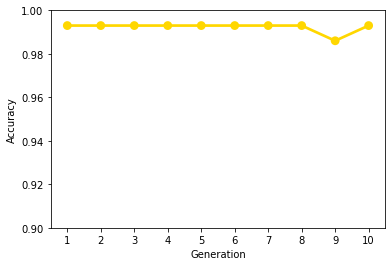

In [32]:
plot(score_bc,0.9,1.0,c = "gold")

## Load Polycystic ovary syndrome (PCOS) Dataset & Preprocessing

- classification case를 위해 Polycystic ovary syndrome (PCOS) Dataset 사용 (Kaggle dataset)
- feature: [' Age (yrs)', 'Weight (Kg)', 'Height(Cm) ', 'BMI', 'Blood Group', 'Pulse rate(bpm) ', 'RR (breaths/min)', 'Hb(g/dl)', 'Cycle(R/I)', 'Cycle length(days)', 'Marraige Status (Yrs)', 'Pregnant(Y/N)', 'No. of aborptions', '  I   beta-HCG(mIU/mL)', 'FSH(mIU/mL)', 'LH(mIU/mL)', 'FSH/LH', 'Hip(inch)', 'Waist(inch)', 'Waist:Hip Ratio', 'TSH (mIU/L)', 'PRL(ng/mL)', 'Vit D3 (ng/mL)', 'PRG(ng/mL)', 'RBS(mg/dl)', 'Weight gain(Y/N)', 'hair growth(Y/N)', 'Skin darkening (Y/N)', 'Hair loss(Y/N)', 'Pimples(Y/N)', 'Fast food (Y/N)', 'Reg.Exercise(Y/N)', 'BP _Systolic (mmHg)', 'BP _Diastolic (mmHg)', 'Follicle No. (L)', 'Follicle No. (R)', 'Avg. F size (L) (mm)', 'Avg. F size (R) (mm)', 'Endometrium (mm)']
- target: ["PCOS (Y/N)"]

In [33]:
data_pcos = pd.read_csv("PCOS_data.csv")
label_pcos = data_pcos["PCOS (Y/N)"]
data_pcos.drop(["Sl. No","Patient File No.","PCOS (Y/N)","Unnamed: 44","II    beta-HCG(mIU/mL)","AMH(ng/mL)"],axis = 1,inplace = True)
data_pcos["Marraige Status (Yrs)"].fillna(data_pcos['Marraige Status (Yrs)'].describe().loc[['50%']][0], inplace = True) 
data_pcos["Fast food (Y/N)"].fillna(1, inplace = True) 

print("PCOS dataset:\n",data_pcos.shape[0],"Records\n",data_pcos.shape[1],"Features")

PCOS dataset:
 541 Records
 39 Features


- 모든 변수가 연속형 변수임을 확인

In [34]:
display(data_pcos.head())

,Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),Hb(g/dl),Cycle(R/I),Cycle length(days),...,Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
0,28,44.6,152.0,19.304017,15,78,22,10.48,2,5,...,0,1,0,110,80,3,3,18.0,18.0,8.5
1,36,65.0,161.5,24.921163,15,74,20,11.70,2,5,...,0,0,0,120,70,3,5,15.0,14.0,3.7
2,33,68.8,165.0,25.270891,11,72,18,11.80,2,5,...,1,1,0,120,80,13,15,18.0,20.0,10.0
3,37,65.0,148.0,29.674945,13,72,20,12.00,2,5,...,0,0,0,120,70,2,2,15.0,14.0,7.5
4,25,52.0,161.0,20.060954,11,72,18,10.00,2,5,...,0,0,0,120,80,3,4,16.0,14.0,7.0


In [35]:
data_pcos.describe()

,Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),Hb(g/dl),Cycle(R/I),Cycle length(days),...,Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
count,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.00000,...,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000
mean,31.430684,59.637153,156.484835,24.319360,13.802218,73.247689,19.243993,11.160037,2.560074,4.94085,...,0.489834,0.513863,0.247689,114.661738,76.927911,6.129390,6.641405,15.018115,15.451701,8.475915
std,5.411006,11.028287,6.033545,4.050810,1.840812,4.430285,1.688629,0.866904,0.901950,1.49202,...,0.500359,0.500270,0.432070,7.384556,5.574112,4.229294,4.436889,3.566839,3.318848,2.165381
min,20.000000,31.000000,137.000000,12.417882,11.000000,13.000000,16.000000,8.500000,2.000000,0.00000,...,0.000000,0.000000,0.000000,12.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,52.000000,152.000000,21.707923,13.000000,72.000000,18.000000,10.500000,2.000000,4.00000,...,0.000000,0.000000,0.000000,110.000000,70.000000,3.000000,3.000000,13.000000,13.000000,7.000000
50%,31.000000,59.000000,156.000000,24.238227,14.000000,72.000000,18.000000,11.000000,2.000000,5.00000,...,0.000000,1.000000,0.000000,110.000000,80.000000,5.000000,6.000000,15.000000,16.000000,8.500000
75%,35.000000,65.000000,160.000000,26.638918,15.000000,74.000000,20.000000,11.700000,4.000000,5.00000,...,1.000000,1.000000,0.000000,120.000000,80.000000,9.000000,10.000000,18.000000,18.000000,9.800000
max,48.000000,108.000000,180.000000,38.900714,18.000000,82.000000,28.000000,14.800000,5.000000,12.00000,...,1.000000,1.000000,1.000000,140.000000,100.000000,22.000000,20.000000,24.000000,24.000000,18.000000


In [36]:
score2 = acc_score(data_pcos, label_pcos)
score2

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Classifier,Accuracy
0,RandomForest,0.882353
1,AdaBoost,0.882353
2,GradientBoosting,0.860294
3,LinearSVM,0.852941
4,Logistic,0.852941
5,DecisionTree,0.838235
6,RadialSVM,0.698529
7,KNeighbors,0.676471


- 기본 classifier 가운데 성능이 좋은 RF 분류기를 선택하여
- GA를 통한 변수 선택법을 했을 때 결과가 잘 나오는지 확인

In [37]:
logmodel = RandomForestClassifier(n_estimators=200, random_state=0)
X_train,X_test, Y_train, Y_test = split(data_pcos,label_pcos)
chromo_df_pcos,score_pcos=generations(data_pcos, label_pcos,
                                      size=100, n_feat=data_pcos.shape[1], n_parents=64, mutation_rate=0.20, n_gen=10,
                                      X_train = X_train, X_test = X_test, Y_train = Y_train, Y_test = Y_test)

C:\Users\YongGon\AppData\Local\Temp/ipykernel_12196/524632877.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  chromosome = np.ones(n_feat,dtype=np.bool)


Best score in generation 1 : [0.9117647058823529]
Best score in generation 2 : [0.9117647058823529]
Best score in generation 3 : [0.9191176470588235]
Best score in generation 4 : [0.9044117647058824]
Best score in generation 5 : [0.9191176470588235]
Best score in generation 6 : [0.9117647058823529]
Best score in generation 7 : [0.9191176470588235]
Best score in generation 8 : [0.9117647058823529]
Best score in generation 9 : [0.9044117647058824]
Best score in generation 10 : [0.9044117647058824]


- 모든 generation에 대해 대략 2% - 4%의 정확도가 향상됨

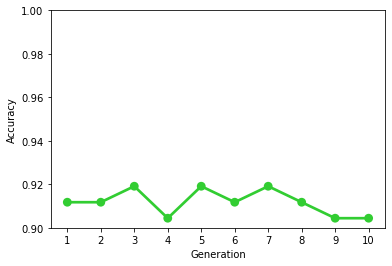

In [38]:
plot(score_pcos,0.9,1.0,c = "limegreen")